# **Hand gesture recognition Using CNN**

This project focuses on building a computer vision system that can recognize and classify hand gestures using deep learning techniques. Hand gesture recognition plays a crucial role in applications such as sign language interpretation, touchless interfaces, and human-computer interaction.

In this project, we use a labeled dataset of hand gesture images and train a Convolutional Neural Network (CNN) to accurately classify gestures into predefined categories such as thumbs up, okay, palm, and more. The model processes grayscale images, learns spatial features, and is then evaluated on its ability to predict gestures from unseen images.

The final system can be extended for real-time gesture detection using webcam input, making it a foundation for more interactive and intelligent systems.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ameerabanup","key":"a5330ced041817daff58b1e74ad24aeb"}'}

## Importing files from kaggle


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d "gti-upm/leapgestrecog"

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.12G/2.13G [00:13<00:00, 244MB/s]
100% 2.13G/2.13G [00:13<00:00, 170MB/s]


In [4]:
import zipfile
import os

zip_path = "/content/leapgestrecog.zip"  # replace with your actual file name
extract_path = "/content/hand_gesture_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
# Print all the folders and no of files in them.
for root, dirs, files in os.walk("/content/hand_gesture_data"):
    print(root, "->", len(dirs), "folders,", len(files), "files")

/content/hand_gesture_data -> 2 folders, 0 files
/content/hand_gesture_data/leapgestrecog -> 1 folders, 0 files
/content/hand_gesture_data/leapgestrecog/leapGestRecog -> 10 folders, 0 files
/content/hand_gesture_data/leapgestrecog/leapGestRecog/02 -> 10 folders, 0 files
/content/hand_gesture_data/leapgestrecog/leapGestRecog/02/03_fist -> 0 folders, 200 files
/content/hand_gesture_data/leapgestrecog/leapGestRecog/02/01_palm -> 0 folders, 200 files
/content/hand_gesture_data/leapgestrecog/leapGestRecog/02/06_index -> 0 folders, 200 files
/content/hand_gesture_data/leapgestrecog/leapGestRecog/02/02_l -> 0 folders, 200 files
/content/hand_gesture_data/leapgestrecog/leapGestRecog/02/07_ok -> 0 folders, 200 files
/content/hand_gesture_data/leapgestrecog/leapGestRecog/02/04_fist_moved -> 0 folders, 200 files
/content/hand_gesture_data/leapgestrecog/leapGestRecog/02/09_c -> 0 folders, 200 files
/content/hand_gesture_data/leapgestrecog/leapGestRecog/02/08_palm_moved -> 0 folders, 200 files
/con

##**Loading Images and Identifying Gestures**

In [6]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

base_dir = "/content/hand_gesture_data/leapGestRecog"
image_size =(64,64)

X=[]
y=[]

gesture_names = {}
label_number=0

# Looping through folders

for folder_name in sorted(os.listdir(base_dir)):
    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue

    for gesture_folder in sorted(os.listdir(folder_path)):
        gesture_folder_path = os.path.join(folder_path, gesture_folder)
        if not os.path.isdir(gesture_folder_path):
            continue

        gesture = gesture_folder[3:]
        if gesture not in gesture_names:
           gesture_names[gesture]= label_number
           label_number += 1

        label= gesture_names[gesture]


        # Looping through all images in gesture files.
        for image_file in os.listdir(gesture_folder_path):
          image_path = os.path.join(gesture_folder_path, image_file)

          # Read and process image
          image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
          if image is None:
             continue
          image = cv2.resize(image, image_size)

          X.append(image)
          y.append(label)

# Convert to numpy arrays

X=np.array(X)
y=np.array(y)

# Normalize (pixel values between 0 and 1) and reshape
X = X / 255.0
X = X.reshape(-1, 64, 64, 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Images loaded:", len(X))
print("Gestures found:", gesture_names)
print("X_train shape:", X_train.shape)


Images loaded: 20000
Gestures found: {'palm': 0, 'l': 1, 'fist': 2, 'fist_moved': 3, 'thumb': 4, 'index': 5, 'ok': 6, 'palm_moved': 7, 'c': 8, 'down': 9}
X_train shape: (16000, 64, 64, 1)


In [7]:
# Save the labels for future use.
import json

with open("label_to_name.json", "w") as f:
    json.dump({v: k for k, v in gesture_names.items()}, f)

##**Random Gestures**

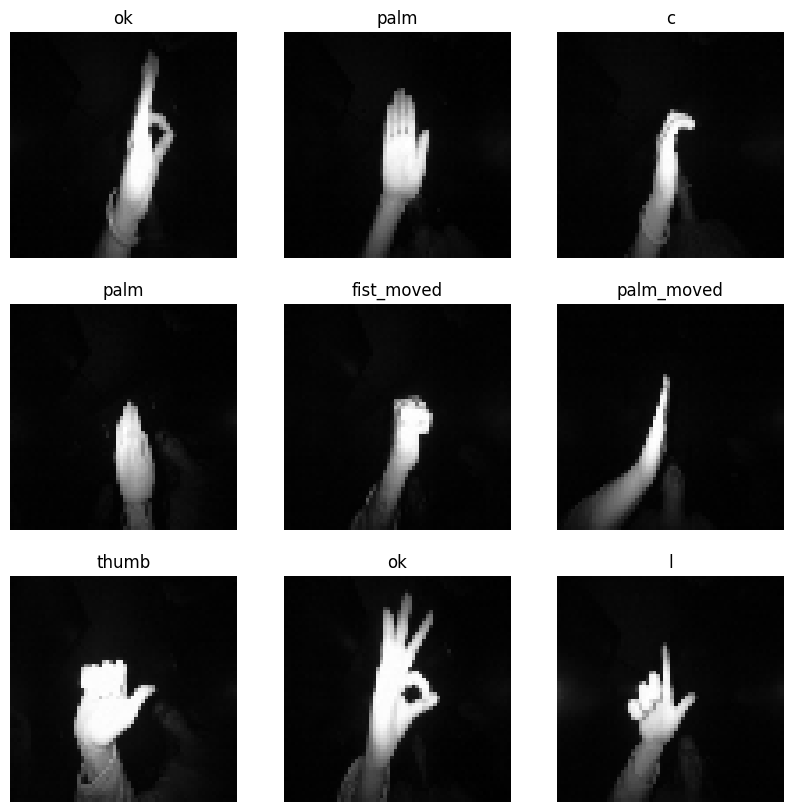

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    index= np.random.randint(0, len(X_train))
    image = X_train[index].reshape(64, 64)
    label = y_train[index]

    # finding gesture name from label
    for gesture, label_value in gesture_names.items():
        if label_value == label:
            gesture_name = gesture
            break

    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(gesture_name)
    plt.axis('off')
plt.show()


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Creating the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(gesture_names), activation='softmax')
    ])

# Compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.6907 - loss: 0.9148 - val_accuracy: 0.9962 - val_loss: 0.0186
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 98ms/step - accuracy: 0.9851 - loss: 0.0539 - val_accuracy: 0.9983 - val_loss: 0.0099
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 101ms/step - accuracy: 0.9871 - loss: 0.0390 - val_accuracy: 0.9992 - val_loss: 0.0039
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 106ms/step - accuracy: 0.9934 - loss: 0.0194 - val_accuracy: 0.9987 - val_loss: 0.0049
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.9950 - loss: 0.0162 - val_accuracy: 0.9990 - val_loss: 0.0033
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - accuracy: 0.9927 - loss: 0.0198 - val_accuracy: 0.9995 - val_loss: 0.0023
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 98ms/step - accuracy: 0.9946 - loss: 0.0165 - val_accuracy: 0.9995 - val_loss: 0.0033
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 102ms/step - accuracy: 0.9960 - loss: 0.01

In [10]:
# Save the model
model.save('model.h5')

In [11]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load  trained model
model = load_model('model.h5')

with open("label_to_name.json", "r") as f:
    label_to_name = json.load(f)

In [12]:
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)         # Convert to grayscale
    resized = cv2.resize(gray, (64, 64))                   # Resize
    normalized = resized / 255.0                           # Normalize
    reshaped = np.expand_dims(normalized, axis=-1)         # Add channel: (64, 64, 1)
    reshaped = np.expand_dims(reshaped, axis=0)            # Final shape: (1, 64, 64, 1)
    return reshaped

In [17]:
import os
print(os.path.exists('/content/Hand gesture.jpg'))

img = cv2.imread('/content/Hand gesture.jpg')  # Unseen image
processed = preprocess_frame(img)
prediction = model.predict(processed)

predicted_index = np.argmax(prediction)
predicted_gesture = label_to_name[str(predicted_index)]

print(f"Predicted Gesture: {predicted_gesture}")

True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Gesture: down


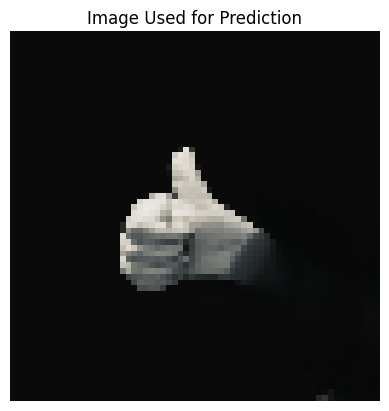

In [18]:
# Load the image
img_path = "/content/Hand gesture.jpg"
img = cv2.imread(img_path)

# Resize the image
img_resized = cv2.resize(img, (64, 64))

# Convert BGR to RGB for displaying in correct colors
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.title("Image Used for Prediction")
plt.axis('off')
plt.show()





## **Conclusion**
The hand gesture recognition project successfully demonstrated how deep learning and computer vision techniques can be used to classify hand gestures from images. By training a Convolutional Neural Network (CNN) on a labeled dataset of grayscale gesture images, the model was able to learn meaningful patterns and accurately predict unseen hand gestures.

This system lays the foundation for real-time gesture-based applications such as touchless user interfaces, sign language interpreters, and virtual controllers. With further enhancements like real-time webcam integration and larger datasets, the model can be made more robust and adaptable to real-world use cases.

